Summary Statistics:
Mean Aggregation: Total Funds: 30000000.0, Max Funds: 64049.40985145985, Min Funds: 40187.824516845394
Median Aggregation: Total Funds: 30000000.0, Max Funds: 71838.51752203763, Min Funds: 34854.07599123858
Quadratic Aggregation: Total Funds: 30000000.0, Max Funds: 81480.1932417274, Min Funds: 32078.25827065148


/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_37135/827178954.py:10: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


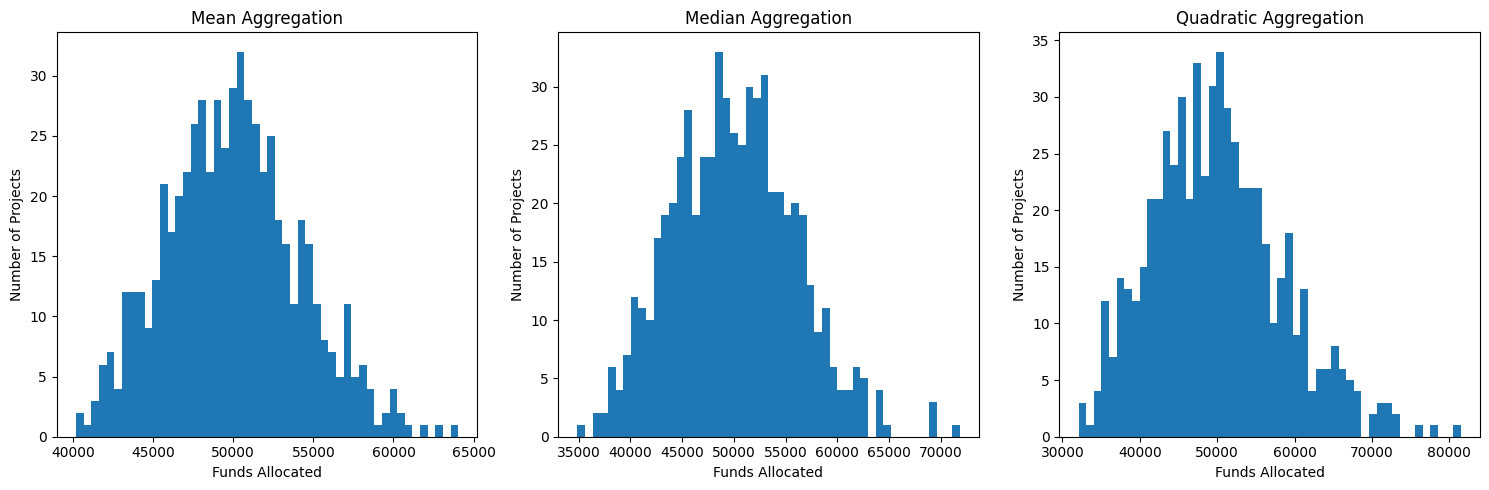

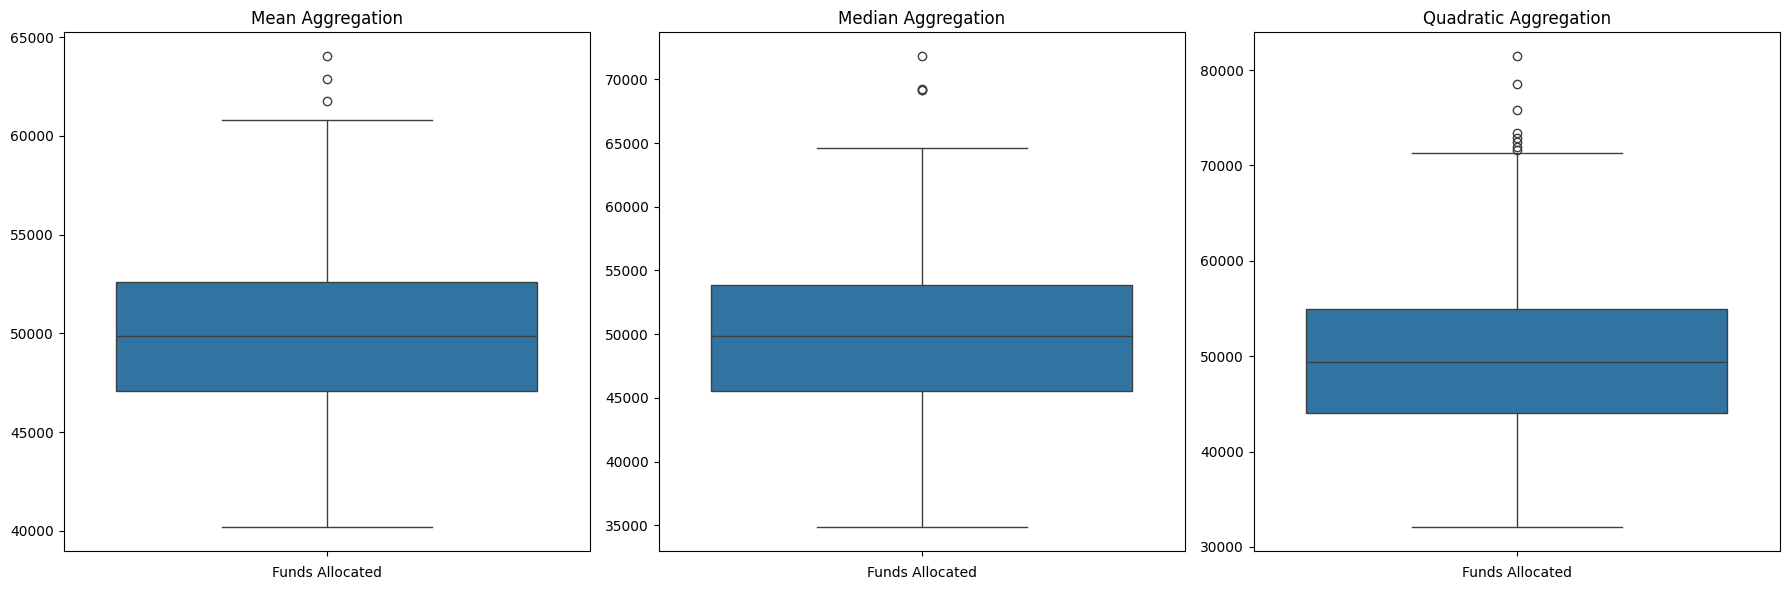

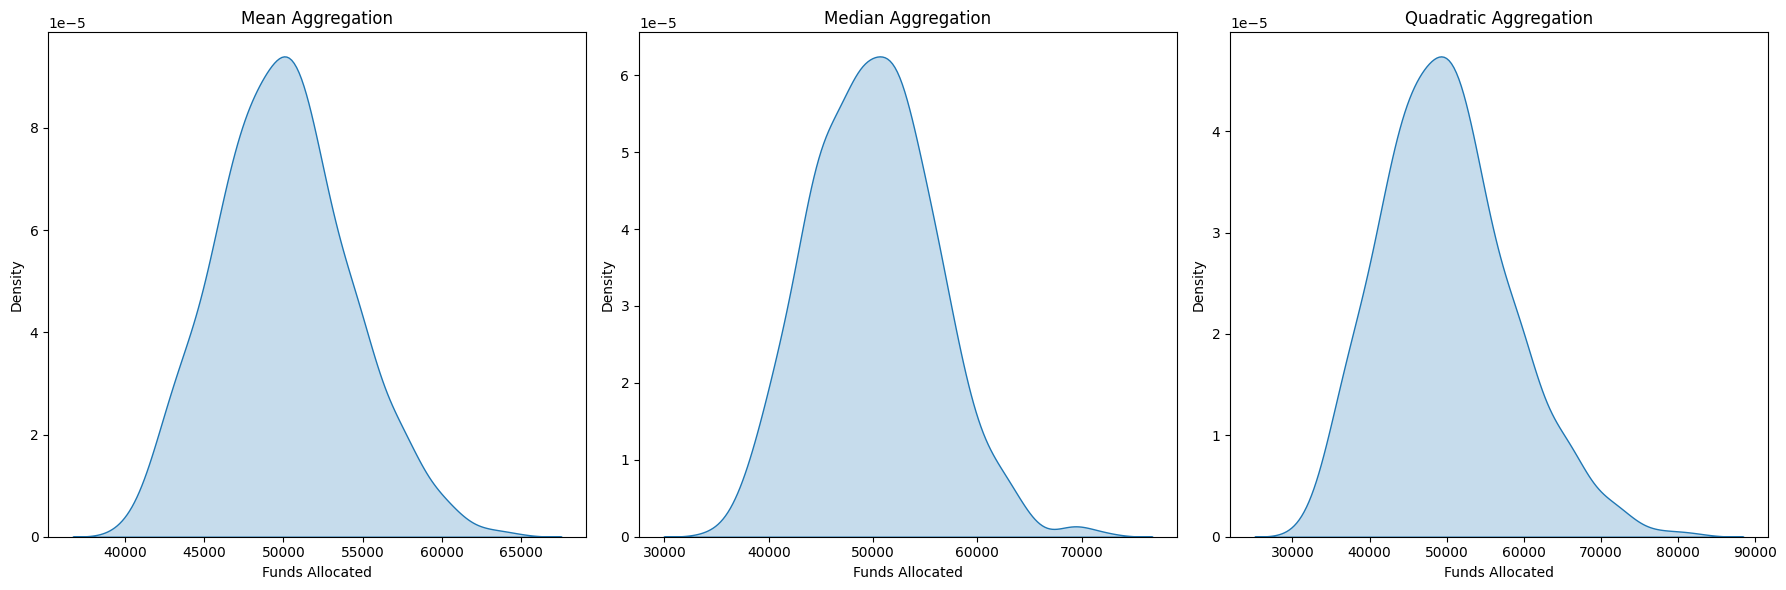

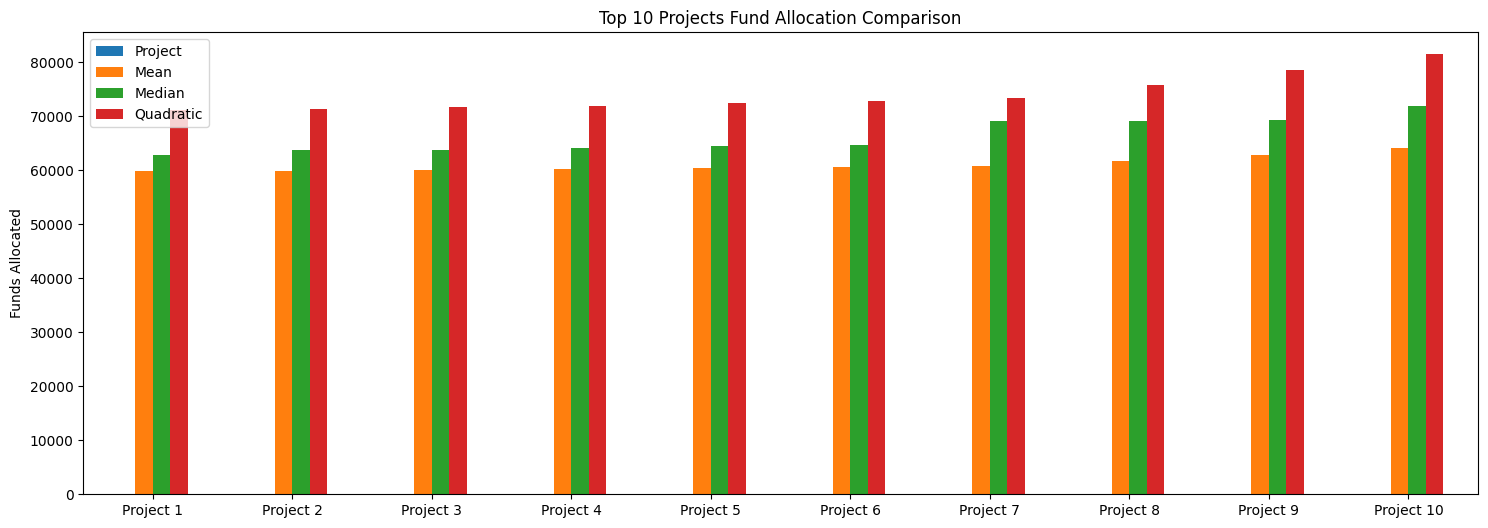

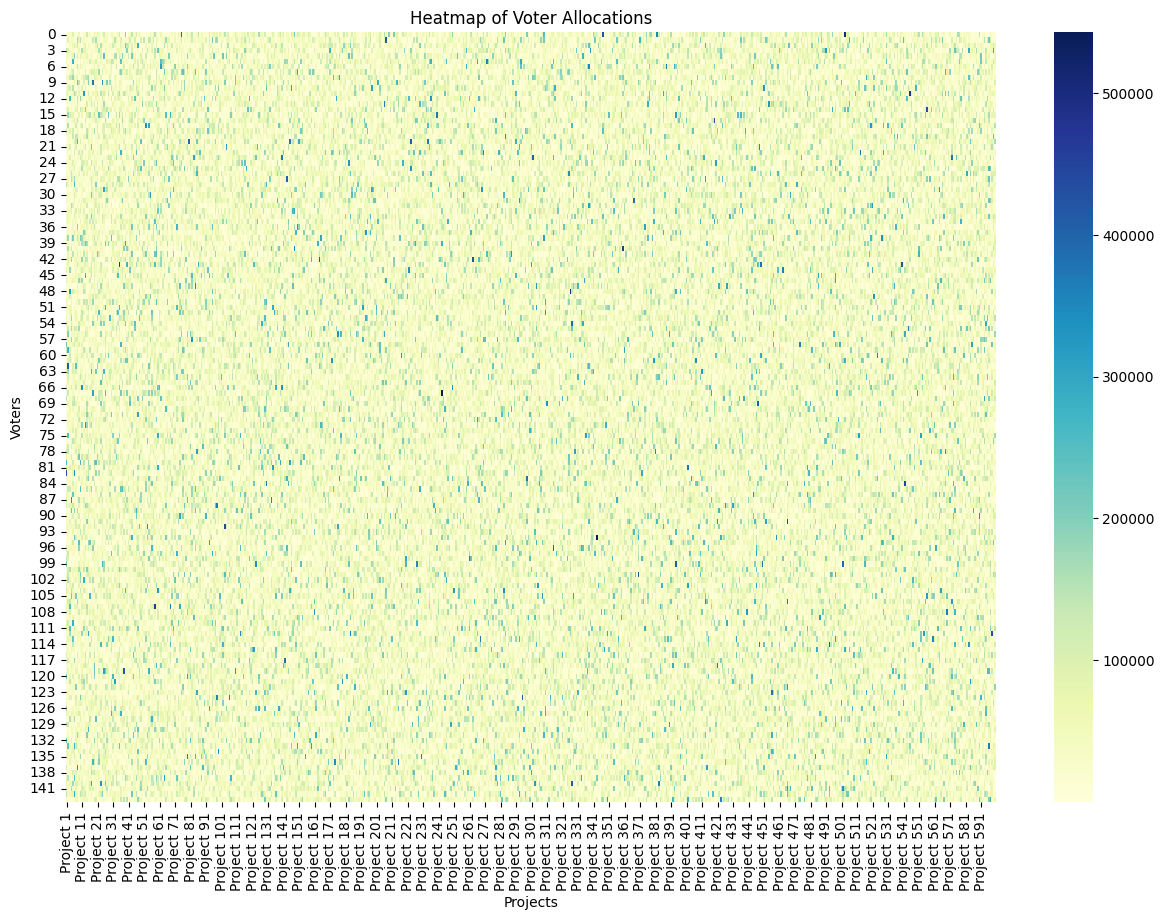

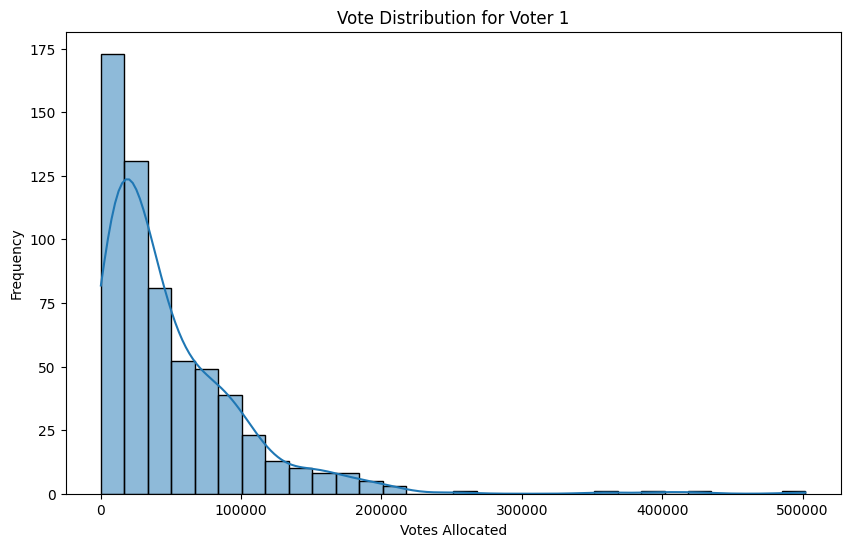

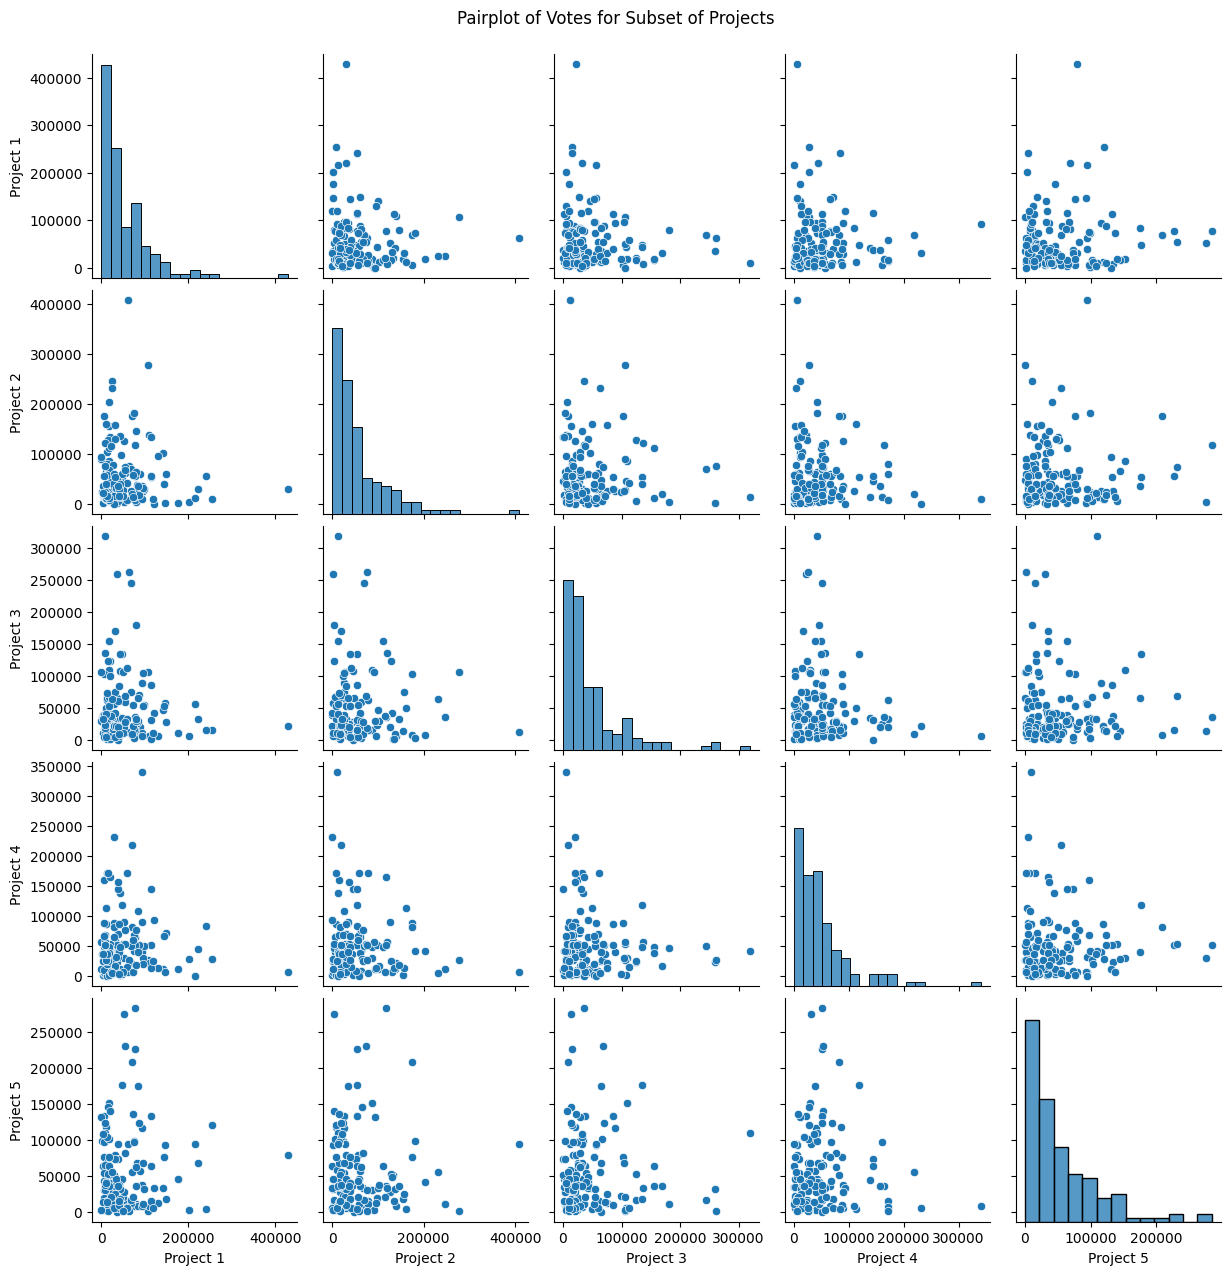

In [12]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from util.plot_results import plot_aggregation_results

class VoterAgent(Agent):
    def __init__(self, unique_id, model, num_projects, total_op_tokens):
        super().__init__(unique_id, model)
        self.num_projects = num_projects
        self.total_op_tokens = total_op_tokens
        self.votes = np.zeros(num_projects)

    def vote(self):
        self.votes = np.random.dirichlet(np.ones(self.num_projects)) * self.total_op_tokens

class ProjectAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.total_votes = 0
        self.funds_allocated = 0

    def add_votes(self, votes):
        self.total_votes += votes

class VotingModel(Model):
    def __init__(self, num_voters, num_projects, total_op_tokens):
        self.num_voters = num_voters
        self.num_projects = num_projects
        self.total_op_tokens = total_op_tokens
        self.schedule = RandomActivation(self)

        self.voters = [VoterAgent(i, self, num_projects, total_op_tokens) for i in range(num_voters)]
        self.projects = [ProjectAgent(i, self) for i in range(num_projects)]

        for voter in self.voters:
            self.schedule.add(voter)
        for project in self.projects:
            self.schedule.add(project)

        self.voting_matrix = np.zeros((num_voters, num_projects))

    def step(self):
        for i, voter in enumerate(self.voters):
            voter.vote()
            self.voting_matrix[i, :] = voter.votes

    
    def aggregate_votes(self, method):
        if method == "mean":
            return mean_aggregation(self.voting_matrix, self.num_voters,self.total_op_tokens)
        elif method == "median":
            return median_aggregation(self.voting_matrix, self.total_op_tokens)
        elif method == "quadratic":
            return quadratic_aggregation(self.voting_matrix, self.total_op_tokens)
        else:
            raise ValueError("Unknown aggregation method")

    def evaluate_bribery(self, target_project, desired_increase, method):
        return calculate_bribery_cost(self, target_project, desired_increase, method)



def mean_aggregation(voting_matrix, num_voters, total_op_tokens):
    total_votes = np.sum(voting_matrix, axis=0)
    mean_votes = total_votes / num_voters
    return mean_votes / np.sum(mean_votes) * total_op_tokens

def median_aggregation(voting_matrix, total_op_tokens):
    median_votes = np.median(voting_matrix, axis=0)
    return median_votes / np.sum(median_votes) * total_op_tokens

def quadratic_aggregation(voting_matrix, total_op_tokens):
    total_votes = np.sum(voting_matrix, axis=0)
    quadratic_votes = total_votes ** 2
    return quadratic_votes / np.sum(quadratic_votes) * total_op_tokens

def calculate_bribery_cost(model, target_project, desired_increase, method):
    bribery_cost, new_voting_matrix, new_allocation = simulate_bribery(
        model, target_project, desired_increase, method
    )
    return bribery_cost, new_voting_matrix, new_allocation

def simulate_bribery(model, target_project, desired_increase, method):
    """
    Simulate a bribery strategy to increase the funds allocated to a target project.
    
    Parameters:
    - model: The VotingModel instance.
    - target_project: Index of the target project to increase funds.
    - desired_increase: Desired increase in funds for the target project.
    - method: Aggregation method to be used ("mean", "median", "quadratic").
    
    Returns:
    - bribery_cost: The cost of the bribery strategy.
    - new_voting_matrix: The new voting matrix after applying the bribery strategy.
    - new_allocation: The new allocation of funds after bribery.
    """
    num_voters, num_projects = model.voting_matrix.shape
    new_voting_matrix = model.voting_matrix.copy()
    
    # Calculate the original allocation
    original_allocation = model.aggregate_votes(method)
    original_funds = original_allocation[target_project]
    
    # Calculate the target allocation
    target_funds = original_funds + desired_increase
    
    bribery_cost = 0
    current_increase = 0
    
    while current_increase < desired_increase:
        for voter in range(num_voters):
            if current_increase >= desired_increase:
                break
            available_funds = new_voting_matrix[voter].sum() - new_voting_matrix[voter, target_project]
            if available_funds > 0:
                shift_amount = min(available_funds, desired_increase - current_increase)
                new_voting_matrix[voter, target_project] += shift_amount
                bribery_cost += shift_amount
                current_increase += shift_amount
        
        # Recalculate the allocation after adjusting votes
        model.voting_matrix = new_voting_matrix
        new_allocation = model.aggregate_votes(method)
        current_increase = new_allocation[target_project] - original_funds
    
    model.voting_matrix = new_voting_matrix  # Reset to the original voting matrix
    
    return bribery_cost, new_voting_matrix, new_allocation

# Run the simulation
model = VotingModel(num_voters=144, num_projects=600, total_op_tokens=30e6)
model.step()

# Apply different aggregation methods
mean_funds = model.aggregate_votes("mean")
median_funds = model.aggregate_votes("median")
quadratic_funds = model.aggregate_votes("quadratic")



## Evaluate Bribery

In [13]:
# Initialize the model
model = VotingModel(num_voters=144, num_projects=600, total_op_tokens=30e6)
model.step()

# Set parameters for bribery evaluation
target_project = 0
desired_increase = 1e6  # Desired increase of 1M OP tokens

# Evaluate bribery resistance for different aggregation methods
for method in ["mean", "median", "quadratic"]:
    bribery_cost, new_voting_matrix, new_allocation = model.evaluate_bribery(target_project, desired_increase, method)
    print(f"Bribery cost for {method} aggregation: {bribery_cost}")
    print(f"New allocation for {method} aggregation: {new_allocation[target_project]} (should be increased by {desired_increase})")


/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_37135/827178954.py:10: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
